# Cooking with NLP part 2

Hello again! Following our first attempt where we used 700 recipes from scraped data, we'll now try again with a database containing 30,000 recipes as well as also exploring Doc2Vec from gensim and see how well it compares with our previously seen methods.



In [2]:
import pandas as pd
import collections
import re
import zipfile
import io
from os import listdir
from os.path import isfile, join
from myscripts import *
import gensim
import logging
import pprint
from collections import OrderedDict
import multiprocessing
cores = multiprocessing.cpu_count()
assert gensim.models.doc2vec.FAST_VERSION > -1, "this will be painfully slow otherwise"

pp = pprint.PrettyPrinter(indent=4)
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 6)

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

data_folder="../data/"
#@@@@@ Now You're Cooking! Export Format

use_old_models=True


c:\users\alexkeenan\appdata\local\programs\python\python36\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Using TensorFlow backend.


In [3]:
try:
    1/use_old_models # if use_old_models=0, then this fails
    cols_to_use=["corpus","name"]
    #for some reason when you load, it creates another index col that it tacks for no reason...
    combined_df=pd.read_csv(os.path.join(data_folder,"processed_all_recipes.csv"),encoding="ISO-8859-1",usecols=cols_to_use)
    
    #has columns  ["corpus","name"]
    print("loaded preprocessed df")
except:
    print("new text preprocessing")
    recipes_df=pd.read_csv(os.path.join(data_folder,"all_recipes.csv"),encoding="ISO-8859-1")
    recipes_df.dropna(inplace=True)
    combined_df=pd.DataFrame()
    #combined_df["corpus"] = recipes_df["ingredients"].map(str) +" "+recipes_df["instructions"]+" "+recipes_df["name"]
    combined_df["corpus"] = recipes_df["ingredients"].map(str) +" "+recipes_df["name"]
    combined_df["name"]=recipes_df["name"]
    
    combined_df=combined_df.sample(frac=1)
    combined_df=combined_df.reset_index(drop=True)

    combined_df.corpus=combined_df.corpus.apply(lambda x:" ".join(text_process(str(x)))) #apparently sometimes x is a float, that's why str() is there
    combined_df.to_csv(os.path.join(data_folder,"processed_all_recipes.csv"))
    print("done preprocessing")

# Turning text into tagged doc2vec objects
        
train_test_dict=train_test(0.9,x=combined_df)
x_train=train_test_dict["x_train"]
x_test=train_test_dict["x_test"]

def processing_train_test_text(train_or_test_df):
    list_of_processed_texts=[]
    for each in train_or_test_df.corpus.tolist():
        list_of_processed_texts.append(str(each).split())
    return list_of_processed_texts

train_processed_tokenized_text=processing_train_test_text(x_train)
test_processed_tokenized_text=processing_train_test_text(x_train)    


loaded preprocessed df


LDA and LSI models

In [4]:
import struct
from gensim import corpora

num_topics=20


data_folder="../data/"
#THE WHOLE PREPROCESSING CHECK THING COULD'VE BEEN DONE EARLIER in the script
#i save my lemmatized words as bin files, to save space + special characters
try:
    1/use_old_models # if use_old_models=0, then this fails
    my_nlp_dict=corpora.Dictionary.load(os.path.join(data_folder, 'my_nlp_'+str(num_topics)+'.dict'))
    #with open(os.path.join(data_folder,"lemmatized_processed.bin"), "rb") as my_input:  
    #    fileContent=my_input.read()
    #    train_processed_tokenized_text = exec(fileContent.decode('utf-8'))
    train_processed_tokenized_text=np.load(os.path.join(data_folder,'train_processed_tokenized_text.npy')).tolist()

except:
    #with open(os.path.join(data_folder,"lemmatized_processed.bin"), "wb") as output:
    #    output.write(str(train_processed_tokenized_text).encode('utf-8'))
    np.save(os.path.join(data_folder,"train_processed_tokenized_text"),train_processed_tokenized_text)
    my_nlp_dict = corpora.Dictionary(train_processed_tokenized_text)
    my_nlp_dict.filter_extremes(no_below=5, no_above=0.2) #in case you want to filter out some words
    my_nlp_dict.save(os.path.join(data_folder, 'my_nlp_'+str(num_topics)+'.dict'))  # store the dictionary, for future reference
    my_nlp_dict=my_nlp_dict.load(os.path.join(data_folder, 'my_nlp_'+str(num_topics)+'.dict'))
    #print(my_nlp_dict)
    
    

# Making the BOW

In [5]:
#from gensim.corpora import Dictionary
#dictionary = Dictionary(train_texts)

try:
    1/use_old_models # if use_old_models=0, then this fails
    bow_corpus = corpora.MmCorpus(os.path.join(data_folder, 'MY_BOW.mm'))
    
except:
    print("creating BOW")
    #STRAIGHT FROM TEXT (COULD BE MEMORY INTENSIVE)
    
    bow_corpus = [my_nlp_dict.doc2bow(text) for text in train_processed_tokenized_text]
    corpora.MmCorpus.serialize(os.path.join(data_folder, 'MY_BOW.mm'), bow_corpus)  # store to disk, for later use
    bow_corpus = corpora.MmCorpus(os.path.join(data_folder, 'MY_BOW.mm')) 
    print("done")

# BOW -> TFIDF -> LSI 

In [6]:
try:
    1/use_old_models # if use_old_models=0, then this fails
    lsi_model = gensim.models.LsiModel.load(os.path.join(data_folder,'lsi_'+str(num_topics)+'.model'))
    print("using old LSI model")
    tfidf_model=gensim.models.TfidfModel.load(os.path.join(data_folder,'Tfidf_'+str(num_topics)+'.model'))
    print("using old TFIDF model")
    corpus_tfidf = tfidf_model[bow_corpus]
except:
    print("creating new tfidf_model")
    tfidf_model = gensim.models.TfidfModel(bow_corpus) 
    
    corpus_tfidf = tfidf_model[bow_corpus]
    print("creating new LSI model")
    %time lsi_model = gensim.models.LsiModel(corpus_tfidf, id2word=my_nlp_dict, num_topics=num_topics) # initialize an LSI transformation
    lsi_model.save(os.path.join(data_folder,'lsi_'+str(num_topics)+'.model'))
    tfidf_model.save(os.path.join(data_folder,'Tfidf_'+str(num_topics)+'.model'))
    print("done")
    #lda = gensim.models.ldamodel.LdaModel(model_corpus, num_topics = n_topics_lda, id2word = id2word, passes = n_passes_lda)
    #gensim.models.ldamodel.LdaModel.save(lda, 'outputs/lda.model')
lsi_corpus = lsi_model[corpus_tfidf] # create a double wrapper over the original corpus: bow->tfidf->fold-in-lsi


using old LSI model
using old TFIDF model


# Similarities matrix built on LSI

In [8]:
from gensim import similarities

try:
    1/use_old_models 
    index = similarities.MatrixSimilarity.load(os.path.join(data_folder, 'lsi_similarity_'+str(num_topics)+'.index'))
    print("loading similarities matrix")
except:
    print("creating new similarities matrix")
    index = similarities.MatrixSimilarity(lsi_corpus)
    index.save(os.path.join(data_folder, 'lsi_similarity_'+str(num_topics)+'.index'))
    index = similarities.MatrixSimilarity.load(os.path.join(data_folder, 'lsi_similarity_'+str(num_topics)+'.index'))


loading similarities matrix


# Can it recognize itself?

In [9]:

test_run=x_train.corpus[0] #picking the first recipe

vec_bow = my_nlp_dict.doc2bow(test_run.split())
#print(vec_bow) #this part works
vec_tfidf=tfidf_model[vec_bow]
#print(vec_tfidf) # you join it with the model, not the corpus
vec_lsi = lsi_model[vec_tfidf] # convert the query to LSI space
sims = index[vec_lsi] # perform a similarity query against the corpus
#print(list(enumerate(sims))) # print (document_number, document_similarity) 2-tuples

top_10=list(sorted(enumerate(sims), key=lambda x: x[1], reverse=True))[:20]
top_10_indexes=[x[0] for x in top_10]
top_10_match_pct=[x[1] for x in top_10]
print("Target recipe at index 0")
print(x_train.name[0])
print("INDEXES")
print(top_10_indexes)
top_10_names=x_train.name[top_10_indexes].values

print("RECIPES")
pp.pprint(list(zip(top_10_names,top_10_match_pct)))



Target recipe at index 0
Rumaki 
INDEXES
[0, 5114, 15664, 4685, 6991, 4267, 17732, 10103, 28528, 23918, 10901, 4630, 24406, 13722, 6770, 28099, 28052, 12676, 14801, 21106]
RECIPES
[   ('Rumaki ', 0.96698177),
    ('Oriental Grilled Chicken ', 0.95149982),
    ('Teriyaki Chicken Delight ', 0.94270492),
    ('Tofu Triangles ', 0.93615127),
    ('Hot & Spicy Chicken ', 0.93612719),
    ('Chinese: Hot & Spicy Chicken (Ma La Tze Gee ', 0.93601215),
    ('Chinese: Hot And Spicy Chicken (Ma La Tze Gee) - Hunan ', 0.93601215),
    ('Chinese Braised Chicken ', 0.93278378),
    ('Crockpot Cowloon Chicken ', 0.93268424),
    ('Baked Teriyaki Whiskey Chicken ', 0.93097496),
    ('Mandarin Soup ', 0.92793053),
    ('Roasted Spare Ribs (Pei Quot) ', 0.92731059),
    ('Crockpot Kowloon Chicken ', 0.92438132),
    ('Yunnan Steamed Pot Chicken ', 0.92310202),
    ('Won-Ton Soup ', 0.92039132),
    ('Salt-Roasted Chicken With Marinade ', 0.91991341),
    ('Oriental Chicken Marinade ', 0.91613233),
    (

# Yes it can.
As you can see above, the selected target recipe was Rumaki with a very high similarity score. This is no big surprise but it tells us the model is working correctly. (For the curious, Rumaki is just cocktail sausages wrapped in bacon.)



# Making a request

Like in my previous post, let's see how well it can handle vague requests. Feel free to try this out yourself!


In [15]:
test_run='spicy meat salad'

vec_bow = my_nlp_dict.doc2bow(test_run.split())
#print(vec_bow) #this part works
vec_tfidf=tfidf_model[vec_bow]
#print(vec_tfidf) # you join it with the model, not the corpus
vec_lsi = lsi_model[vec_tfidf] # convert the query to LSI space
sims = index[vec_lsi] # perform a similarity query against the corpus
#print(list(enumerate(sims))) # print (document_number, document_similarity) 2-tuples

top_10=list(sorted(enumerate(sims), key=lambda x: x[1], reverse=True))[:20]
top_10_indexes=[x[0] for x in top_10]
top_10_match_pct=[x[1] for x in top_10]
print("INDEXES")
print(top_10_indexes)
top_10_names=x_train.name[top_10_indexes].values

print("RECIPES")
pp.pprint(list(zip(top_10_names,top_10_match_pct)))

INDEXES
[23888, 8732, 27949, 19665, 15911, 8008, 11508, 1388, 24574, 20455, 12667, 28763, 28755, 24526, 846, 4045, 10823, 12663, 12848, 15279]
RECIPES
[   ('Barvarian Sausage Salad ', 0.92748308),
    ('Bayerischer Wurstsalat (Barvarian Sausage Salad) ', 0.9272368),
    ('Bayerischer Wurstsalat (Barvarian Sausage Sala ', 0.90767419),
    ('Bayerischer Wurstsalat (Barvarian Sausage Sal ', 0.90714264),
    ('Cajun Coleslaw ', 0.88668299),
    ('Lobster Salad ', 0.87653732),
    ('Lobster Salad ', 0.87653732),
    ('Avocado-Tofu-Egg Dip ', 0.87410486),
    ('Avocado Tofu Egg Dip ', 0.87410486),
    ('Sweet Salad Dressing Mix ', 0.86581641),
    ('Cajun Potato Salad ', 0.86413437),
    ('Turkey Salad Stuffed Eggs ', 0.85851169),
    ("Justin Wilson's Tuna Salad ", 0.85167211),
    ("Justin's Tuna Salad ", 0.85074282),
    ('Eggplant Relish ', 0.8463912),
    ('Italian Slaw ', 0.84473038),
    ('Thousand Island Dressing ', 0.8444435),
    ('Potato Salad Dressing ', 0.84361196),
    ('Spam S

I asked for 'spicy meat salad' and the best suggestions include Barvarian sausage salad, Cajun Coleslaw, Lobster salad, etc. I'd say the suggestions are spot on.

# Which topic does it resemble most? What words best represent those topics?

In [42]:
def check_topics_words(model,model_vec,nber_words=10,nber_topics=10):
    #getting the top nber_words most significant ones
    model_vec=sorted(vec_lsi, key=lambda x: abs(x[1]),reverse=True)[:nber_topics]

    topic_numbers, topic_similarities = zip(*model_vec)
    print("topic numbers are")
    print(topic_numbers)
    print("----")
    

    for each_topic_number in topic_numbers:
        print(model.print_topic(topicno=each_topic_number,topn=nber_words))
        print("----")
        

check_topics_words(lsi_model,vec_lsi,10)

topic numbers are
(31, 33, 0, 19, 40, 16, 42, 1, 25, 38)
----
0.210*"rice" + -0.209*"ginger" + 0.204*"chicken" + 0.185*"mustard" + -0.184*"soy" + 0.179*"steak" + -0.174*"fish" + -0.172*"carrot" + -0.171*"pineapple" + 0.165*"cook"
----
-0.252*"shrimp" + -0.211*"half" + 0.207*"rice" + -0.194*"gm" + -0.183*"banana" + -0.176*"ounce" + 0.172*"red" + 0.152*"almond" + -0.149*"pecan" + 0.143*"chip"
----
0.162*"ground" + 0.153*"sauce" + 0.146*"slice" + 0.142*"beef" + 0.141*"chocolate" + 0.139*"cheese" + 0.139*"bake" + 0.138*"fresh" + 0.132*"tomato" + 0.126*"mince"
----
-0.402*"shrimp" + -0.254*"banana" + 0.251*"corn" + -0.231*"rice" + 0.178*"honey" + 0.171*"wheat" + 0.166*"chicken" + 0.162*"steak" + -0.149*"bread" + -0.148*"cook"
----
-0.358*"pineapple" + 0.262*"roast" + -0.252*"dice" + 0.251*"ingredient" + 0.196*"pecan" + 0.168*"potato" + 0.158*"melt" + 0.155*"slice" + -0.153*"cherry" + 0.149*"strawberry"
----
-0.350*"potato" + 0.348*"peanut" + -0.231*"corn" + 0.217*"apple" + -0.177*"dice" + -

How the model groups certain ingredients together won't always make sense to us. In reality if this were a serious project used commercially, the number of subjects would either be set based on what we already know about the data, or tweaked until we felt the groups made sense. 

# Let's try increasing the number of topics from 20 to 50

In [33]:
num_topics=50

try:
    1/use_old_models # if use_old_models=0, then this fails
    lsi_model = gensim.models.LsiModel.load(os.path.join(data_folder,'lsi_'+str(num_topics)+'.model'))
    print("using old LSI model")
    tfidf_model=gensim.models.TfidfModel.load(os.path.join(data_folder,'Tfidf_'+str(num_topics)+'.model'))
    print("using old TFIDF model")
    corpus_tfidf = tfidf_model[bow_corpus]
except:
    print("creating new tfidf_model")
    tfidf_model = gensim.models.TfidfModel(bow_corpus) 
    
    corpus_tfidf = tfidf_model[bow_corpus]
    print("creating new LSI model")
    %time lsi_model = gensim.models.LsiModel(corpus_tfidf, id2word=my_nlp_dict, num_topics=num_topics) # initialize an LSI transformation
    lsi_model.save(os.path.join(data_folder,'lsi_'+str(num_topics)+'.model'))
    tfidf_model.save(os.path.join(data_folder,'Tfidf_'+str(num_topics)+'.model'))
    print("done")
    #lda = gensim.models.ldamodel.LdaModel(model_corpus, num_topics = n_topics_lda, id2word = id2word, passes = n_passes_lda)
    #gensim.models.ldamodel.LdaModel.save(lda, 'outputs/lda.model')
lsi_corpus = lsi_model[corpus_tfidf] # create a double wrapper over the original corpus: bow->tfidf->fold-in-lsi

try:
    1/use_old_models 
    index = similarities.MatrixSimilarity.load(os.path.join(data_folder, 'lsi_similarity_'+str(num_topics)+'.index'))
    print("loading similarities matrix")
except:
    print("creating new similarities matrix")
    index = similarities.MatrixSimilarity(lsi_corpus)
    index.save(os.path.join(data_folder, 'lsi_similarity_'+str(num_topics)+'.index'))
    index = similarities.MatrixSimilarity.load(os.path.join(data_folder, 'lsi_similarity_'+str(num_topics)+'.index'))



using old LSI model
using old TFIDF model
loading similarities matrix


In [34]:
test_run='spicy meat salad'

vec_bow = my_nlp_dict.doc2bow(test_run.split())
#print(vec_bow) #this part works
vec_tfidf=tfidf_model[vec_bow]
#print(vec_tfidf) # you join it with the model, not the corpus
vec_lsi = lsi_model[vec_tfidf] # convert the query to LSI space
sims = index[vec_lsi] # perform a similarity query against the corpus
#print(list(enumerate(sims))) # print (document_number, document_similarity) 2-tuples

top_10=list(sorted(enumerate(sims), key=lambda x: x[1], reverse=True))[:20]
top_10_indexes=[x[0] for x in top_10]
top_10_match_pct=[x[1] for x in top_10]
print("INDEXES")
print(top_10_indexes)
top_10_names=x_train.name[top_10_indexes].values

print("RECIPES")
pp.pprint(list(zip(top_10_names,top_10_match_pct)))


INDEXES
[8732, 23888, 28763, 28755, 12663, 24526, 9192, 7254, 27949, 19665, 13584, 25704, 3959, 4718, 6910, 11895, 16104, 13424, 26181, 29574]
RECIPES
[   ('Bayerischer Wurstsalat (Barvarian Sausage Salad) ', 0.8107602),
    ('Barvarian Sausage Salad ', 0.81046391),
    ('Turkey Salad Stuffed Eggs ', 0.8019563),
    ("Justin Wilson's Tuna Salad ", 0.78364539),
    ('Potato Salad Dressing ', 0.78361166),
    ("Justin's Tuna Salad ", 0.78264034),
    ("Bonnie's Potato Salad ", 0.77218527),
    ("Joyce's Easy Deviled Eggs ", 0.74774295),
    ('Bayerischer Wurstsalat (Barvarian Sausage Sala ', 0.74241978),
    ('Bayerischer Wurstsalat (Barvarian Sausage Sal ', 0.74213636),
    ('Cavalier Dressing ', 0.73880136),
    ('Deluxe Potato Salad ', 0.73818612),
    ('Basil Potato & Egg Salad ', 0.73207104),
    ('Basil, Potato And Egg Salad ', 0.73207104),
    ('Basil, Potato And Egg Salad ', 0.73207104),
    ('Basil Potato & Egg Salad ', 0.73207104),
    ('Potato Salad (Prodigy) ', 0.73139638),
 

Here we see that the similarities overall have decreased. As the recipes are stretched across 50 topics, they are less and less similar to each other. But the overall ordering still seems good. Is this better than before? Hard to say. For one, there seems to be less mention of anything spicy.

# NOW FOR LDA

You specify the number of LDA topics here

In [10]:
#trying with LDA first
lda_num_topics=1000 #for lda it seems I need to increase the number of topics in order to make it discriminating enough

try:
    1/use_old_models # if use_old_models=0, then this fails
    lda_model = gensim.models.LdaModel.load(os.path.join(data_folder,'lda_'+str(lda_num_topics)+'.model'))
    
    print("using old LDA model")
except:
    print("CREATING LDA")

    print("creating LDA model")
    %time lda_model = gensim.models.LdaModel(corpus_tfidf, id2word=my_nlp_dict, num_topics=lda_num_topics)
    lda_model.save(os.path.join(data_folder,'lda_'+str(lda_num_topics)+'.model'))
    
lda_corpus=lda_model[corpus_tfidf]

using old LDA model


# SIMILARITIES MATRIX WITH LDA

In [11]:

try:
    1/use_old_models 
    index = similarities.MatrixSimilarity.load(os.path.join(data_folder, 'lda_similarity_'+str(lda_num_topics)+'.index'))
    print("loading similarities matrix")
except:
    print("creating new similarities matrix")
    index = similarities.MatrixSimilarity(lda_corpus)
    index.save(os.path.join(data_folder, 'lda_similarity_'+str(lda_num_topics)+'.index'))
    index = similarities.MatrixSimilarity.load(os.path.join(data_folder, 'lda_similarity_'+str(lda_num_topics)+'.index'))

loading similarities matrix


# Can it recognize itself?

In [12]:
test_run=x_train.corpus[0]

vec_bow = my_nlp_dict.doc2bow(test_run.split())
#print(vec_bow) #this part works
vec_tfidf=tfidf_model[vec_bow]
#print(vec_tfidf) # you join it with the model, not the corpus
vec_lda = lda_model[vec_tfidf] # convert the query to LSI space
sims = index[vec_lda] # perform a similarity query against the corpus
#print(list(enumerate(sims))) # print (document_number, document_similarity) 2-tuples

top_10=list(sorted(enumerate(sims), key=lambda x: x[1], reverse=True))[:20]
top_10_indexes=[x[0] for x in top_10]
top_10_match_pct=[x[1] for x in top_10]
print("Target recipe at index 0")
print(x_train.name[0])
print("INDEXES")
print(top_10_indexes)
top_10_names=x_train.name[top_10_indexes].values

print("RECIPES")
pp.pprint(list(zip(top_10_names,top_10_match_pct)))



Target recipe at index 0
Rumaki 
INDEXES
[0, 1109, 20036, 3885, 68, 4430, 20679, 1635, 15772, 24372, 8869, 3868, 6886, 25384, 22863, 20572, 28358, 16554, 2687, 19084]
RECIPES
[   ('Rumaki ', 0.99997115),
    ('Mou-Shou Pork ', 0.68599117),
    ('BEEF KWANGTON #1 ', 0.68405294),
    ('Beef Kwangton B1 ', 0.6430223),
    ('Seven Happiness Soup ', 0.62071407),
    ('Seven Happiness Soup ', 0.62055957),
    ('Chinese Hamburger ', 0.61910391),
    ('Kiwifruit Ice ', 0.60157776),
    ('Chicken With Zucchini ', 0.59555656),
    ('Hot & Sour Soup     -Kvnh17b ', 0.59267223),
    ('Fire Pot ', 0.58878523),
    ('Fire Pot ', 0.58748519),
    ('Cantonese Egg Foo Yung ', 0.57591391),
    ('Sukiyaki- [Weight Watchers New International Cookbook] ', 0.55940592),
    ('Foo Yung Don (Egg Foo Yung) ', 0.5500977),
    ('Chinese Pork-Lettuce Rolls ', 0.54797667),
    ('Chinese: Spicy Chicken (Le Tze Gee) - Shangtu ', 0.52837127),
    ('Hot & Sour Chicken Soup ', 0.52731884),
    ('Golden Tiger Dumpling So

# Yes it can!

Once again it can pick itself out. One thing of note though, it seems for LDA you need to specify a much higher number of topics than lsi for it to be discriminating enough. Too few number of topics and all the recipes look too alike. 

I specified 1000 topics but in reality that might be too much. If you look at the similarity percentages, the second suggestion has a massive drop off in similarity. That might mean that we've overfit the data. If thinking of the 'topics space' where one could see all the 1000 clusters of recipes, Rumaki might be the only one in his group. 

Feel free to play around with the number of topics and see for yourself.


# Making a request

In [13]:
test_run='spicy meat salad'

vec_bow = my_nlp_dict.doc2bow(test_run.split())
#print(vec_bow) #this part works
vec_tfidf=tfidf_model[vec_bow]
#print(vec_tfidf) # you join it with the model, not the corpus
vec_lda = lda_model[vec_tfidf] # convert the query to LSI space
sims = index[vec_lda] # perform a similarity query against the corpus
#print(list(enumerate(sims))) # print (document_number, document_similarity) 2-tuples

top_10=list(sorted(enumerate(sims), key=lambda x: x[1], reverse=True))[:20]
top_10_indexes=[x[0] for x in top_10]
top_10_match_pct=[x[1] for x in top_10]
print("INDEXES")
print(top_10_indexes)
top_10_names=x_train.name[top_10_indexes].values

print("RECIPES")
pp.pprint(list(zip(top_10_names,top_10_match_pct)))


INDEXES
[24577, 1788, 14356, 1446, 24945, 10396, 4045, 20455, 21677, 12665, 17453, 27621, 6173, 12645, 26539, 20233, 10389, 7279, 9095, 4083]
RECIPES
[   ('Spicy Steak Marinade ', 0.64964396),
    ('Spicy Steak Marinade ', 0.64833283),
    ('Spicy Steak Marinade ', 0.64468384),
    ('Chicken Cassandra ', 0.48927861),
    ('Chicken Cassandra+++fggt98b ', 0.48921406),
    ("Klein's Kanchi Chicken ", 0.47572663),
    ('Italian Slaw ', 0.4398284),
    ('Sweet Salad Dressing Mix ', 0.4324199),
    ('Easy Spicy Meat Loaf ', 0.43042564),
    ('Good Reasons Italian Dressing ', 0.42516854),
    ('Spicy Grilled Chicken Rbtn28a ', 0.42421454),
    ('Spicy Fresh Country Sausage ', 0.41986454),
    ('Dixie Boiled Salad Dressing ', 0.4115974),
    ('Spicy Turkey Loaf ', 0.41049859),
    ('Siberian Pelmeni (Meat-Filled Noodles With Va ', 0.40292296),
    ('Spicy Breakfast Pattycakes ', 0.39681509),
    ('Italian-Cheese Dressing ', 0.39315721),
    ('Big Bucket In The Sky Chicken (Kfc) ', 0.39266184),

Unfortunately this doesn't look as good as with the LSI model. I can see that it capture the spicy meat part. 

Let's try again with fewer topics...

# Which topic does it resemble most? What words best represent those topics?

In [31]:
check_topics_words(lda_model,vec_lda,nber_words=10)


topic numbers are
(51, 539, 723)
----
0.664*"spicy" + 0.058*"ground" + 0.048*"black" + 0.046*"crush" + 0.034*"clove" + 0.031*"fresh" + 0.020*"sauce" + 0.019*"coarsely" + 0.017*"steak" + 0.012*"cut"
----
0.306*"salad" + 0.233*"italian" + 0.203*"dress" + 0.047*"fggt98b" + 0.037*"tomato" + 0.030*"wine" + 0.028*"season" + 0.020*"chicken" + 0.017*"pkg" + 0.016*"white"
----
0.699*"meat" + 0.079*"cook" + 0.041*"beef" + 0.037*"tomato" + 0.033*"crush" + 0.031*"celery" + 0.027*"hot" + 0.011*"single" + 0.008*"ginger" + 0.003*"16"
----


# And finally now for Doc2Vec

## What is Doc2Vec?

It's a way of turning documents into dense matrices with the help of neural networks. The original paper can be found here https://arxiv.org/pdf/1405.4053v2.pdf

I won't really be going over the theory in detail, but know that there are two version of Doc2Vec. 

One is based on the continuous bag of words model (Give the model a context and it will give you a word)

While the other version is more akin to the skip gram model (Give me a word and I will give you a context)

# 1.Based on Continuous Bag of Words

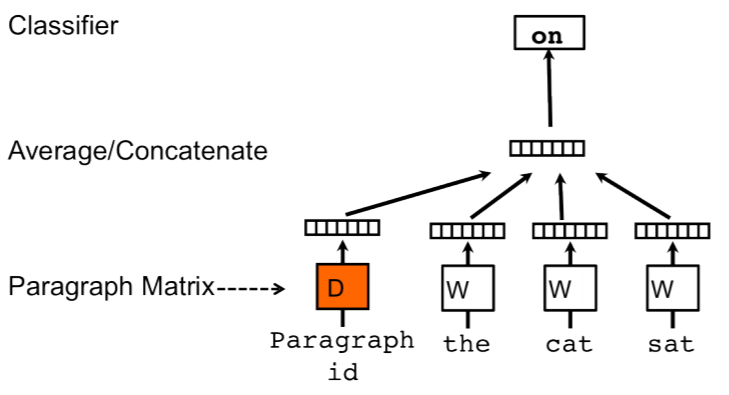

In [44]:
from IPython.display import Image
Image(filename=os.path.join(data_folder,'doc2vec_cbow.png')) 



A key thing to keep in mind is that the words of all the articles are trained and formed by the same matrix, for all articles. It is trained very similarly to a normal CBOW with a sliding window. In the above example you feed it ['the','cat','sat'], we turn these into their BOW vectors and send them through a neural net layer to predict "on" in this case. In the next article, we could have ['the','cat','sat'] --> in. The model will have to generalize.

Now on top of that for every sliding window input you will have the paragraph (or document) id. This is either averaged or concatenated in just as if it was another word in the sentence. This document id is the TAG. The tag is whatever we want to identify, group the document by. It could be just the name of the article (like in our case, the name of the recipes) or it could be a binary "good" or "bad" which you attribute to all your documents (think sentiment analysis for movie reviews).

There are two phases to the traning, one where both the paragraph id and vocabulary are trained at the same time, followed by phase where the weights for the vocabulary stays fixed ona







In [15]:
# Doc2Vec corpus

def read_corpus(df,tokens_only=False): 
    #print(df.head())
    for line in df.itertuples():
        text_name=line[2]
        text_input=line[1]

        if tokens_only:
            #return df.corpus.tolist()
            yield text_input
            #yield gensim.utils.simple_preprocess(line)

        else:
            #yield gensim.models.doc2vec.TaggedDocument(gensim.utils.simple_preprocess(line),[i])
            #return gensim.models.doc2vec.TaggedDocument(df.corpus.tolist(),df.ID.tolist())
            yield gensim.models.doc2vec.TaggedDocument([text_input],[text_name])
            #the i is the tag in this case
            #notice here that you're giving back a MODEL
            #tagged document only works 1 document at time
            
train_corpus=list(read_corpus(x_train))
test_corpus=list(read_corpus(x_test,tokens_only=True))



# Checking to see how many words I want to keep

In [16]:
from gensim.models.doc2vec import Doc2Vec,TaggedDocument
pre = Doc2Vec(min_count=0)
pre.scan_vocab(train_corpus) 

for num in range(0, 20):
    print('min_count: {}, size of vocab: '.format(num), pre.scale_vocab(min_count=num, dry_run=True)['memory']['vocab']/700)


min_count: 0, size of vocab:  19707.85714285714
min_count: 1, size of vocab:  19707.85714285714
min_count: 2, size of vocab:  1417.857142857143
min_count: 3, size of vocab:  70.0
min_count: 4, size of vocab:  20.0
min_count: 5, size of vocab:  3.5714285714285716
min_count: 6, size of vocab:  0.0
min_count: 7, size of vocab:  0.0
min_count: 8, size of vocab:  0.0
min_count: 9, size of vocab:  0.0
min_count: 10, size of vocab:  0.0
min_count: 11, size of vocab:  0.0
min_count: 12, size of vocab:  0.0
min_count: 13, size of vocab:  0.0
min_count: 14, size of vocab:  0.0
min_count: 15, size of vocab:  0.0
min_count: 16, size of vocab:  0.0
min_count: 17, size of vocab:  0.0
min_count: 18, size of vocab:  0.0
min_count: 19, size of vocab:  0.0


In [17]:
#CHOOSE YOUR MIN COUNT HERE
MIN_COUNT=1

In [46]:

#dm=1  #means distributed memory method which is the default
#dm=0 # means dbow method
starting_alpha=0.025

D2V_models = [
    
    # PV-DBOW 
    #Doc2Vec(dm=0, dbow_words=1, size=20, window=2,alpha=starting_alpha, min_alpha=starting_alpha, min_count=MIN_COUNT, workers=cores,iter=1),
    #Doc2Vec(dm=0, dbow_words=1, size=20, window=4,alpha=starting_alpha, min_alpha=starting_alpha, min_count=MIN_COUNT, workers=cores,iter=1),
    # PV-DBOW 
    #Doc2Vec(dm=0, dbow_words=1, size=20, window=4,alpha=starting_alpha, min_alpha=starting_alpha, min_count=MIN_COUNT, workers=cores,iter=1),
    #Doc2Vec(dm=0, dbow_words=1, size=20, window=20,alpha=starting_alpha, min_alpha=starting_alpha, min_count=MIN_COUNT, workers=cores,iter=1),
    # PV-DM 
    #Doc2Vec(dm=1, dm_mean=1, size=20, window=2,alpha=starting_alpha, min_alpha=starting_alpha, min_count=MIN_COUNT, workers=cores,iter=1),
    #Doc2Vec(dm=1, dm_mean=1, size=20, window=10,alpha=starting_alpha, min_alpha=starting_alpha, min_count=MIN_COUNT, workers=cores,iter=1),
    # PV-DM 
    #Doc2Vec(dm=1, dm_mean=1, size=20, window=4,alpha=starting_alpha, min_alpha=starting_alpha, min_count=MIN_COUNT, workers=cores,iter=1),
    #Doc2Vec(dm=1, dm_mean=1, size=20, window=20,alpha=starting_alpha, min_alpha=starting_alpha, min_count=MIN_COUNT, workers=cores,iter=1),
    
    
    #these are bad
    # PV-DBOW 
    Doc2Vec(dm=0, size=300, window=8,alpha=starting_alpha, min_alpha=starting_alpha, min_count=MIN_COUNT, workers=cores,iter=1),
    Doc2Vec(dm=0, size=300, window=4,alpha=starting_alpha, min_alpha=starting_alpha, min_count=MIN_COUNT, workers=cores,iter=1),
    # PV-DBOW 
    Doc2Vec(dm=0, size=600, window=8,alpha=starting_alpha, min_alpha=starting_alpha, min_count=MIN_COUNT, workers=cores,iter=1),
    Doc2Vec(dm=0, size=600, window=4,alpha=starting_alpha, min_alpha=starting_alpha, min_count=MIN_COUNT, workers=cores,iter=1),
    # PV-DM w/average
    Doc2Vec(dm=1, size=300, window=8,alpha=starting_alpha, min_alpha=starting_alpha, min_count=MIN_COUNT, workers=cores,iter=1),
    Doc2Vec(dm=1, size=300, window=4,alpha=starting_alpha, min_alpha=starting_alpha, min_count=MIN_COUNT, workers=cores,iter=1),
    # PV-DM w/average
    Doc2Vec(dm=1, size=600, window=8,alpha=starting_alpha, min_alpha=starting_alpha, min_count=MIN_COUNT, workers=cores,iter=1),
    Doc2Vec(dm=1, size=600, window=4,alpha=starting_alpha, min_alpha=starting_alpha, min_count=MIN_COUNT, workers=cores,iter=1),
    
]

D2V_models[0].build_vocab(train_corpus) # 
for model in D2V_models[1:]:
    model.reset_from(D2V_models[0])
    print(model)


Doc2Vec(dbow,d300,n5,s0.001,t4)
Doc2Vec(dbow,d600,n5,s0.001,t4)
Doc2Vec(dbow,d600,n5,s0.001,t4)
Doc2Vec(dm/m,d300,n5,w8,s0.001,t4)
Doc2Vec(dm/m,d300,n5,w4,s0.001,t4)
Doc2Vec(dm/m,d600,n5,w8,s0.001,t4)
Doc2Vec(dm/m,d600,n5,w4,s0.001,t4)


In [47]:
models_by_name = OrderedDict((str(model).replace("/","_").replace(",","_").replace(".","_"), model) for model in D2V_models)

In [48]:
try:
    1/use_old_models # if use_old_models=0, then this fails

    for name, train_model in models_by_name.items():
        train_model = gensim.models.Doc2Vec.load(os.path.join(data_folder,name+'.mm'))

    print("loading model")
except:
    from random import shuffle
    print("training model")
    epochs=100
    
    last_alpha=0.001
    alpha_step=(starting_alpha-last_alpha)/epochs
    

    alpha=starting_alpha
        
    
    for epoch in range(epochs):
        print("NOW AT EPOCH %i"%epoch)
        shuffle(train_corpus) #shuffling causes a problem for some reason
        
        for name, train_model in models_by_name.items():
            print("training "+name)
            train_model.alpha, train_model.min_alpha = alpha, alpha
            train_model.train(train_corpus, total_examples=len(train_corpus), epochs=1)    
        
        alpha-=alpha_step

    #when you train your vocabulary, make sure your articles look like =[['word1','word2',...]] and not['word1 word2']
    #D2V_model = gensim.models.doc2vec.Doc2Vec(size=1000, window=10,min_count=0, iter=55)
    #D2V_model.build_vocab(train_corpus)
    #%time D2V_model.train(train_corpus,total_examples=D2V_model.corpus_count, epochs=D2V_model.iter)
    #D2V_model.save(os.path.join(data_folder,'recipes_d2v.mm'))
    print("done")
    

training model
NOW AT EPOCH 0
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:16:44,614: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:16:45,085: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:16:45,645: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:16:46,212: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:16:46,786: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:16:47,385: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 1
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:16:47,880: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:16:48,357: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:16:48,907: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:16:49,451: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:16:50,007: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:16:50,559: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 2
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:16:51,056: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:16:51,546: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:16:52,129: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:16:52,682: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:16:53,245: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:16:53,855: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 3
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:16:54,325: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:16:54,801: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:16:55,359: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:16:55,914: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:16:56,504: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:16:57,082: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 4
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:16:57,552: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:16:58,031: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:16:58,629: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:16:59,214: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:16:59,818: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:17:00,435: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 5
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:17:00,924: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:17:01,403: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:17:01,957: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:17:02,515: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:17:03,065: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:17:03,620: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 6
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:17:04,113: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:17:04,590: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:17:05,143: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:17:05,696: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:17:06,284: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:17:06,873: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 7
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:17:07,357: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:17:07,827: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:17:08,376: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:17:08,923: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:17:09,467: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:17:10,020: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 8
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:17:10,504: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:17:10,977: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:17:11,526: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:17:12,080: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:17:12,651: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:17:13,201: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 9
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:17:13,700: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:17:14,184: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:17:14,732: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:17:15,280: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:17:15,831: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:17:16,382: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 10
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:17:16,869: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:17:17,348: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:17:17,903: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:17:18,470: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:17:19,074: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:17:19,663: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 11
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:17:20,144: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:17:20,617: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:17:21,161: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:17:21,703: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:17:22,244: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:17:22,795: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 12
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:17:23,279: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:17:23,736: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:17:24,281: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:17:24,832: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:17:25,408: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:17:25,998: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 13
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:17:26,482: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:17:26,958: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:17:27,540: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:17:28,090: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:17:28,672: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:17:29,226: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 14
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:17:29,722: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:17:30,199: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:17:30,763: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:17:31,319: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:17:31,878: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:17:32,441: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 15
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:17:32,919: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:17:33,391: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:17:33,971: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:17:34,533: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:17:35,083: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:17:35,648: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 16
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:17:36,140: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:17:36,615: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:17:37,160: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:17:37,713: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:17:38,271: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:17:38,821: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 17
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:17:39,308: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:17:39,788: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:17:40,337: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:17:40,892: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:17:41,435: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:17:41,995: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 18
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:17:42,491: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:17:42,965: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:17:43,512: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:17:44,063: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:17:44,620: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:17:45,172: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 19
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:17:45,658: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:17:46,132: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:17:46,683: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:17:47,232: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:17:47,780: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:17:48,337: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 20
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:17:48,832: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:17:49,300: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:17:49,846: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:17:50,395: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:17:50,949: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:17:51,515: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 21
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:17:51,999: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:17:52,463: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:17:53,016: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:17:53,573: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:17:54,119: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:17:54,680: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 22
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:17:55,164: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:17:55,638: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:17:56,184: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:17:56,741: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:17:57,304: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:17:57,850: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 23
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:17:58,334: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:17:58,812: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:17:59,362: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:17:59,913: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:18:00,463: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:18:01,010: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 24
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:18:01,503: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:18:01,974: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:18:02,523: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:18:03,080: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:18:03,637: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:18:04,192: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 25
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:18:04,682: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:18:05,152: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:18:05,701: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:18:06,257: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:18:06,805: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:18:07,371: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 26
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:18:07,850: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:18:08,326: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:18:08,872: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:18:09,427: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:18:09,984: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:18:10,528: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 27
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:18:11,009: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:18:11,475: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:18:12,018: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:18:12,564: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:18:13,105: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:18:13,693: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 28
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:18:14,172: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:18:14,643: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:18:15,186: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:18:15,741: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:18:16,288: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:18:16,834: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 29
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:18:17,313: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:18:17,783: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:18:18,330: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:18:18,872: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:18:19,415: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:18:19,968: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 30
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:18:20,447: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:18:20,917: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:18:21,464: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:18:22,001: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:18:22,546: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:18:23,085: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 31
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:18:23,566: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:18:24,029: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:18:24,574: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:18:25,110: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:18:25,649: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:18:26,191: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 32
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:18:26,675: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:18:27,142: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:18:27,673: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:18:28,212: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:18:28,755: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:18:29,288: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 33
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:18:29,768: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:18:30,236: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:18:30,772: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:18:31,308: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:18:31,846: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:18:32,391: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 34
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:18:32,867: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:18:33,338: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:18:33,873: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:18:34,412: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:18:34,952: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:18:35,499: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 35
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:18:35,980: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:18:36,451: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:18:37,017: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:18:37,556: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:18:38,089: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:18:38,635: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 36
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:18:39,117: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:18:39,584: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:18:40,121: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:18:40,657: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:18:41,201: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:18:41,746: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 37
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:18:42,224: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:18:42,693: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:18:43,232: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:18:43,773: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:18:44,312: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:18:44,910: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 38
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:18:45,383: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:18:45,850: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:18:46,387: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:18:46,959: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:18:47,547: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:18:48,086: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 39
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:18:48,564: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:18:49,031: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:18:49,574: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:18:50,128: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:18:50,707: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:18:51,289: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 40
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:18:51,764: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:18:52,272: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:18:52,909: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:18:53,503: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:18:54,100: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:18:54,689: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 41
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:18:55,161: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:18:55,629: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:18:56,164: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:18:56,707: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:18:57,244: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:18:57,789: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 42
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:18:58,261: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:18:58,730: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:18:59,269: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:18:59,811: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:19:00,360: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:19:00,960: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 43
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:19:01,439: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:19:01,910: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:19:02,455: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:19:02,993: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:19:03,539: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:19:04,085: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 44
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:19:04,567: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:19:05,035: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:19:05,569: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:19:06,110: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:19:06,655: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:19:07,196: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 45
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:19:07,672: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:19:08,139: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:19:08,682: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:19:09,224: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:19:09,765: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:19:10,309: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 46
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:19:10,793: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:19:11,260: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:19:11,799: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:19:12,333: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:19:12,873: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:19:13,419: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 47
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:19:13,897: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:19:14,363: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:19:14,902: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:19:15,446: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:19:15,986: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:19:16,535: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 48
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:19:17,017: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:19:17,488: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:19:18,024: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:19:18,564: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:19:19,106: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:19:19,648: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 49
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:19:20,125: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:19:20,593: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:19:21,127: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:19:21,670: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:19:22,213: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:19:22,761: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 50
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:19:23,240: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:19:23,711: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:19:24,248: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:19:24,787: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:19:25,325: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:19:25,866: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 51
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:19:26,347: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:19:26,810: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:19:27,390: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:19:27,967: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:19:28,517: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:19:29,061: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 52
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:19:29,540: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:19:30,005: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:19:30,546: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:19:31,085: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:19:31,631: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:19:32,172: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 53
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:19:32,669: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:19:33,136: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:19:33,679: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:19:34,216: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:19:34,754: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:19:35,306: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 54
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:19:35,781: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:19:36,248: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:19:36,787: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:19:37,325: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:19:37,865: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:19:38,410: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 55
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:19:38,890: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:19:39,362: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:19:39,902: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:19:40,442: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:19:40,978: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:19:41,525: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 56
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:19:42,000: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:19:42,471: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:19:43,008: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:19:43,551: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:19:44,094: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:19:44,637: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 57
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:19:45,118: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:19:45,585: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:19:46,129: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:19:46,665: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:19:47,201: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:19:47,748: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 58
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:19:48,220: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:19:48,688: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:19:49,220: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:19:49,761: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:19:50,305: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:19:50,853: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 59
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:19:51,332: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:19:51,802: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:19:52,345: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:19:52,886: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:19:53,427: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:19:53,967: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 60
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:19:54,451: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:19:54,915: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:19:55,456: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:19:55,991: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:19:56,531: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:19:57,078: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 61
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:19:57,556: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:19:58,023: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:19:58,563: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:19:59,096: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:19:59,638: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:20:00,179: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 62
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:20:00,654: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:20:01,128: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:20:01,673: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:20:02,257: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:20:02,839: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:20:03,395: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 63
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:20:03,881: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:20:04,358: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:20:04,923: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:20:05,483: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:20:06,033: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:20:06,607: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 64
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:20:07,094: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:20:07,567: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:20:08,114: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:20:08,666: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:20:09,224: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:20:09,782: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 65
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:20:10,272: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:20:10,757: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:20:11,304: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:20:11,850: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:20:12,398: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:20:12,947: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 66
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:20:13,435: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:20:13,897: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:20:14,443: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:20:14,986: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:20:15,576: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:20:16,168: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 67
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:20:16,652: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:20:17,128: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:20:17,678: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:20:18,226: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:20:18,776: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:20:19,329: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 68
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:20:19,821: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:20:20,297: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:20:20,843: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:20:21,399: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:20:21,962: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:20:22,523: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 69
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:20:23,007: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:20:23,483: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:20:24,037: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:20:24,592: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:20:25,148: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:20:25,707: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 70
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:20:26,198: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:20:26,669: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:20:27,220: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:20:27,778: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:20:28,331: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:20:28,888: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 71
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:20:29,378: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:20:29,857: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:20:30,415: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:20:30,968: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:20:31,518: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:20:32,075: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 72
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:20:32,563: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:20:33,036: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:20:33,579: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:20:34,120: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:20:34,666: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:20:35,224: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 73
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:20:35,707: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:20:36,182: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:20:36,769: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:20:37,325: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:20:37,879: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:20:38,435: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 74
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:20:38,914: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:20:39,387: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:20:39,934: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:20:40,470: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:20:41,010: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:20:41,559: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 75
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:20:42,045: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:20:42,519: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:20:43,075: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:20:43,628: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:20:44,175: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:20:44,770: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 76
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:20:45,251: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:20:45,728: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:20:46,264: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:20:46,808: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:20:47,353: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:20:47,896: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 77
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:20:48,375: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:20:48,846: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:20:49,387: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:20:49,927: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:20:50,467: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:20:51,021: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 78
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:20:51,499: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:20:51,965: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:20:52,508: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:20:53,051: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:20:53,592: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:20:54,132: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 79
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:20:54,608: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:20:55,080: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:20:55,616: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:20:56,163: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:20:56,701: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:20:57,240: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 80
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:20:57,716: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:20:58,183: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:20:58,721: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:20:59,260: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:20:59,802: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:21:00,349: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 81
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:21:00,837: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:21:01,300: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:21:01,842: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:21:02,379: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:21:02,917: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:21:03,456: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 82
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:21:03,938: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:21:04,403: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:21:04,943: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:21:05,482: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:21:06,023: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:21:06,568: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 83
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:21:07,046: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:21:07,515: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:21:08,056: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:21:08,592: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:21:09,131: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:21:09,672: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 84
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:21:10,156: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:21:10,625: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:21:11,164: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:21:11,700: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:21:12,245: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:21:12,788: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 85
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:21:13,268: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:21:13,733: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:21:14,268: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:21:14,809: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:21:15,349: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:21:15,893: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 86
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:21:16,375: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:21:16,841: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:21:17,375: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:21:17,915: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:21:18,488: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:21:19,036: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 87
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:21:19,515: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:21:19,981: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:21:20,524: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:21:21,060: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:21:21,604: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:21:22,152: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 88
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:21:22,634: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:21:23,099: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:21:23,639: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:21:24,184: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:21:24,730: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:21:25,273: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 89
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:21:25,750: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:21:26,220: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:21:26,756: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:21:27,299: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:21:27,836: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:21:28,383: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 90
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:21:28,868: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:21:29,337: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:21:29,876: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:21:30,419: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:21:30,964: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:21:31,508: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 91
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:21:31,983: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:21:32,455: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:21:33,013: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:21:33,551: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:21:34,093: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:21:34,644: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 92
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:21:35,129: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:21:35,595: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:21:36,132: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:21:36,674: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:21:37,216: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:21:37,760: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 93
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:21:38,244: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:21:38,725: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:21:39,320: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:21:39,864: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:21:40,400: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:21:40,945: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 94
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:21:41,423: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:21:41,897: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:21:42,431: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:21:42,968: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:21:43,511: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:21:44,057: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 95
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:21:44,535: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:21:45,002: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:21:45,547: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:21:46,087: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:21:46,623: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:21:47,168: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 96
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:21:47,650: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:21:48,118: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:21:48,652: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:21:49,188: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:21:49,736: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:21:50,276: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 97
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:21:50,755: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:21:51,220: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:21:51,760: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:21:52,297: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:21:52,841: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:21:53,379: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 98
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:21:53,852: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:21:54,316: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:21:54,858: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:21:55,395: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:21:55,939: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:21:56,483: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


NOW AT EPOCH 99
training Doc2Vec(dbow_d300_n5_s0_001_t4)


2017-08-18 15:21:56,966: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dbow_d600_n5_s0_001_t4)


2017-08-18 15:21:57,427: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w8_s0_001_t4)


2017-08-18 15:21:57,969: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d300_n5_w4_s0_001_t4)


2017-08-18 15:21:58,511: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w8_s0_001_t4)


2017-08-18 15:21:59,050: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


training Doc2Vec(dm_m_d600_n5_w4_s0_001_t4)


2017-08-18 15:21:59,591: WARNING: under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


done


# can it recognize itself?

Unfortunately, after all this, it doesn't seem to do as good a job as the previous methods seen before...

In [49]:
for name, train_model in models_by_name.items():

    print(name)
    inferred_vector=train_model.infer_vector(train_corpus[0].words)
    sims=train_model.docvecs.most_similar([inferred_vector],topn=10)
    print("guesses were")
    print(sims)
    print("answer was ")
    print(train_corpus[0].tags)
    print("----")
    
    

Doc2Vec(dbow_d300_n5_s0_001_t4)
guesses were
[('Chocolate Fantasy Cheesecake ', 0.2311915159225464), ('Individual Cherry Cheesecake ', 0.21800042688846588), ('Grilled Prawn W/Tequila & Nectarine Cream Sauce ', 0.20166105031967163), ('Low-Cal Brownies ', 0.19787496328353882), ('Steamed Fish With Ginger ', 0.1972135305404663), ('Spiced Cornbread ', 0.1964753270149231), ('Strawberry Shortcake Squares ', 0.1961410939693451), ('Corn Chowder(C) (Lacto) ', 0.1952270120382309), ("Grandma Weiss's Kimmel Soup ", 0.1939014196395874), ('Chinese Beef Jerky ', 0.193346306681633)]
answer was 
['Salmon Sushi ']
----
Doc2Vec(dbow_d600_n5_s0_001_t4)
guesses were
[('Spiced Cornbread ', 0.18554265797138214), ('Steamed Fish With Ginger & Onions ', 0.16951081156730652), ('Chocolate Fantasy Cheesecake ', 0.15151645243167877), ('Lemon Tea Bread ', 0.14163050055503845), ('Pork Loin In Mustard Sauce ', 0.14092785120010376), ('Goat Soup ', 0.14019480347633362), ('Keitetyt Ravut (Dill-Flavored Crayfish) ', 0.1377

# save these models? (only if they're good)

In [22]:
#for name, train_model in models_by_name.items():
#    train_model.save(os.path.join(data_folder,name+'.mm'))


# Assessing your model

See how many of these docs can it properly identify.

In [23]:
all_collections=[]
number_of_similarities=len(train_corpus)

number_of_docs=len(train_corpus)
for name, train_model in models_by_name.items():
    
    ranks=[]
    second_rank=[]
    for index,tag_object in enumerate(train_corpus): 
        doc_id=tag_object[1][0]#note that doc_id is your TAG
        inferred_vector=train_model.infer_vector(train_corpus[index].words)
        #gives back an ARRAY
        #calling model.docvecs summons all the vecs of the model
        sims=train_model.docvecs.most_similar([inferred_vector],topn=number_of_similarities)
        #sims gives the top 20 similar vectors
        #sims is a list of two variables -> docid and sim
        #so below you first do for docid, sim in sims and then you only collect the docid
        #you basically collect all the ids of the docs that were most similar
        #and then you look for your original doc_id by index.
        #if it's at 0, then it means that it guessed correctly.
        #the correct article was it its best prediction
        rank=[docid for docid, sim in sims].index(doc_id)
        ranks.append(rank)
        second_rank.append(sims[1]) #We do this so that we can see what was in second position
    #print(name)
    #print(collections.Counter(ranks))
    all_collections.append((name,collections.Counter(ranks)))

    #rank=[tag_id for tag_id, sim in sims].index(doc_id)

KeyboardInterrupt: 

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

number_of_similarities=20
#plt.rcParams['figure.figsize'] = (15, 15)

number_of_docs=len(train_corpus)
acc_percentages={}


nber_of_graphs=len(all_collections)
graphs_per_row=2
nber_of_rows= np.ceil(nber_of_graphs/graphs_per_row)

nber_of_rows_number=nber_of_rows*100
graphs_per_row_number=graphs_per_row*10

i=1
base_number=nber_of_rows_number+graphs_per_row_number

plt.rcParams['figure.figsize'] = (15, 3*nber_of_rows)
#['revenueDifferencedRollingStandardization','revenueRollingNormalization','revenueDifferencedRollingNormalization']:
    
for each_column in bar_data.columns:    

    plt.subplot(base_number+i) 
    labels, values = zip(*counter.items())
    indexes = np.arange(len(labels))
    width = 1
    
    acc_percentages[name]=counter[0]/number_of_docs
    
    plt.bar(indexes, values, width)
    plt.xticks(indexes + width * 0.5, labels)
    
    plt.title(name)
    i+=1
    plt.tight_layout()

plt.show() 


In [ ]:
all_collections[0]

#pprint(all_collections)

import numpy as np
import matplotlib.pyplot as plt

number_of_similarities=len(train_corpus)
number_of_docs=len(train_corpus)
acc_percentages={}

nber_of_graphs=len(all_collections)
graphs_per_row=2
nber_of_rows= np.ceil(nber_of_graphs/graphs_per_row)

nber_of_rows_number=nber_of_rows*100
graphs_per_row_number=graphs_per_row*10

i=1
base_number=nber_of_rows_number+graphs_per_row_number

plt.rcParams['figure.figsize'] = (15, 3*nber_of_rows)


for each_collection in all_collections:
    name=each_collection[0]
    counter=each_collection[1]
    
    plot_location=base_number+i
    plt.subplot(plot_location)

    labels, values = zip(*counter.items())
    indexes = np.arange(len(labels))
    width = 1

    acc_percentages[name]=counter[0]/number_of_docs
    plt.bar(indexes, values, width)
    plt.xticks(indexes + width * 0.5, labels)

    plt.title(name)
    i+=1

plt.show() 

# looking at their accuracy...

In [ ]:
acc_percentages

In [ ]:

import operator
winning_model_name = sorted(acc_percentages.items(), key=operator.itemgetter(0))[0][0]
winning_model=models_by_name[winning_model_name]

# looking at most similar, median and most dissimilar texts

In [ ]:
doc_index=0

inferred_vector=winning_model.infer_vector(train_corpus[doc_index].words)

sims=winning_model.docvecs.most_similar([inferred_vector],topn=len(winning_model.docvecs))


print('Document ({}): «{}»\n'.format(doc_index, ' '.join(train_corpus[doc_index].words)))
print(u'SIMILAR/DISSIMILAR DOCS PER MODEL %s:\n' % winning_model)
for label, index in [('MOST', 0), ('MEDIAN', len(sims)//2), ('LEAST', len(sims) - 1)]:
    print(u'%s %s: «%s»\n' % (label, sims[index], ' '.join(train_corpus[index].words)))

In [ ]:
# Pick a random document from the test corpus and infer a vector from the model
doc_id = random.randint(0, len(test_corpus))
inferred_vector = winning_model.infer_vector(test_corpus[doc_id])
sims = winning_model.docvecs.most_similar([inferred_vector], topn=len(winning_model.docvecs))

# Compare and print the most/median/least similar documents from the train corpus
print('Test Document ({}): «{}»\n'.format(doc_id, ' '.join(test_corpus[doc_id])))
print(u'SIMILAR/DISSIMILAR DOCS PER MODEL %s:\n' % winning_model)
for label, index in [('MOST', 0), ('MEDIAN', len(sims)//2), ('LEAST', len(sims) - 1)]:
    print(u'%s %s: «%s»\n' % (label, sims[index], ' '.join(train_corpus[index].words)))

# Talk to the chef

In [ ]:

request=text_process("I want a meat pie with a mexican twist")

#what I want here is a name 
#it's not necessarily most similar that I want, I'm looking to add the words to to each other. I think.

#need an lstm for this? hopefully not. 

answers=winning_model.most_similar(positive=request, negative=[])

print(answers)

print("suggested meal")
answer=D2V_model.most_similar(positive=[D2V_model.infer_vector(request)], negative=[], topn=1)
print(answer)

# WORD2VEC


try:
    1/use_old_models # if use_old_models=0, then this fails
    W2V_model = gensim.models.Word2Vec.load(os.path.join(data_folder,'recipes_w2v.mm'))
    print("loading model")
except:
    print("training model")

    
    #Word2Vec model must take in [['text1word1,'text1word2'],['text2word1',...]
    W2V_model=gensim.models.Word2Vec(train_processed_tokenized_text,min_count=1)
    #the in_count=1 IS SO IMPORTANT. LOST 1 hour because of that. 
    W2V_model.save(os.path.join(data_folder,'recipes_w2v.mm'))
    
W2V_model.similarity('bread', 'pasta')
W2V_model.most_similar(positive=['bread','meat'],negative=["salad"],topn=2)
W2V_model.similarity('water', 'juice')
W2V_model.similarity('beef', 'pork')
W2V_model.similarity('lb', 'oz')
W2V_model.similarity('beef', 'chicken')
W2V_model.similarity('oil', 'butter')



# Talk to the chef

request=text_process("I want a meat pie with a mexican twist")

#what I want here is a name 
#it's not necessarily most similar that I want, I'm looking to add the words to to each other. I think.

#need an lstm for this? hopefully not. 

answers=W2V_model.most_similar(positive=request, negative=[])

print(answers)

print("suggested meal")
answer=D2V_model.most_similar(positive=[D2V_model.infer_vector(request)], negative=[], topn=1)
print(answer)

# can it recognize itself?

#D2V_model.infer_vector(D2V_model)
inferred_vector=D2V_model.infer_vector(train_corpus[0].words)
sims=D2V_model.docvecs.most_similar([inferred_vector],topn=1)

print(sims)
print(train_corpus[0][1])